---
# 0. Contexte


- **row_id** : (int64) ID code for the row.
- **timestamp** : (int64) the time in milliseconds between this user interaction and the first event completion from that user.
- **user_id** : (int32) ID code for the user.
- **content_id** : (int16) ID code for the user interaction
- **content_type_id** : (int8) 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture.
- **task_container_id** : (int16) Id code for the batch of questions or lectures. For example, a user might see three questions in a row before seeing the explanations for any of them. Those three would all share a task_container_id.
- **user_answer** : (int8) the user's answer to the question, if any. Read -1 as null, for lectures.
- **answered_correctly** : (int8) if the user responded correctly. Read -1 as null, for lectures.
- **prior_question_elapsed_time** : (float32) The average time in milliseconds it took a user to answer each question in the previous question bundle, ignoring any lectures in between. Is null for a user's first question bundle or lecture. Note that the time is the average time a user took to solve each question in the previous bundle.
- **prior_question_had_explanation** : (bool) Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Typically the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback.

---
# 1. Importation des données d'entraînements et exploration préliminaire

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("default")
from IPython.display import Image
from functions import *

In [2]:
%%time

# Source https://www.kaggle.com/rohanrao/tutorial-on-reading-large-datasets/
path = "C:/riiid-test-answer-prediction/train.csv"
train = pd.read_csv(path)
train = train.astype({'row_id': 'int64',
                      'timestamp': 'int64',
                      'user_id': 'int32',
                      'content_id': 'int16',
                      'content_type_id': 'int8',
                      'task_container_id': 'int16',
                      'user_answer': 'int8',
                      'answered_correctly': 'int8',
                      'prior_question_elapsed_time': 'float32',
                      'prior_question_had_explanation': 'boolean'})

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101230332 entries, 0 to 101230331
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int32  
 3   content_id                      int16  
 4   content_type_id                 int8   
 5   task_container_id               int16  
 6   user_answer                     int8   
 7   answered_correctly              int8   
 8   prior_question_elapsed_time     float32
 9   prior_question_had_explanation  boolean
dtypes: boolean(1), float32(1), int16(2), int32(1), int64(2), int8(3)
memory usage: 3.1 GB
Wall time: 4min 52s


In [3]:
train.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,<NA>
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False


In [4]:
train.isna().sum()

row_id                                  0
timestamp                               0
user_id                                 0
content_id                              0
content_type_id                         0
task_container_id                       0
user_answer                             0
answered_correctly                      0
prior_question_elapsed_time       2351538
prior_question_had_explanation     392506
dtype: int64

Le jeu de données d'entraînement est conséquent; plus de 100 millions de lignes. Il est nécessaire de procéder à une profonde exploration et éventuellement un profond nettoyage.

# 2. Nettoyage des utilisateurs
## 2-1. Constitution du dataframe user

In [5]:
n_user = train.user_id.nunique()
print(f'Il y a {n_user} utilisateurs')

Il y a 393656 utilisateurs


In [6]:
%%time

agg = {'row_id' : 'count',
       'timestamp' : lambda x: convert_from_ms(x.max())[0],
       'answered_correctly' : lambda x: round(x.mean() * 100)}

user_info = train.groupby('user_id').agg(agg)
user_info = user_info.rename(columns={'row_id' : 'nb_interactions',
                                   'timestamp' : 'nb_jours',
                                   'answered_correctly' : 'score'})
user_info

Wall time: 1min 58s


,nb_interactions,nb_jours,score
user_id,,,
115,46,7,70
124,30,0,23
2746,20,0,50
5382,128,24,63
8623,112,9,60
...,...,...,...
2147470770,228,32,75
2147470777,758,154,68
2147481750,50,0,76


In [7]:
user_info.describe(percentiles=[.05, .25, .5, .75, 0.95])

,nb_interactions,nb_jours,score
count,393656.000000,393656.000000,393656.000000
mean,257.154297,59.157815,53.002441
std,747.550934,122.216187,16.028939
min,1.000000,0.000000,-14.000000
5%,14.000000,0.000000,23.000000
25%,30.000000,0.000000,42.000000
50%,41.000000,4.000000,55.000000
75%,157.000000,52.000000,65.000000
95%,1175.000000,332.000000,76.000000
max,17917.000000,1011.000000,100.000000


Wall time: 28.4 s


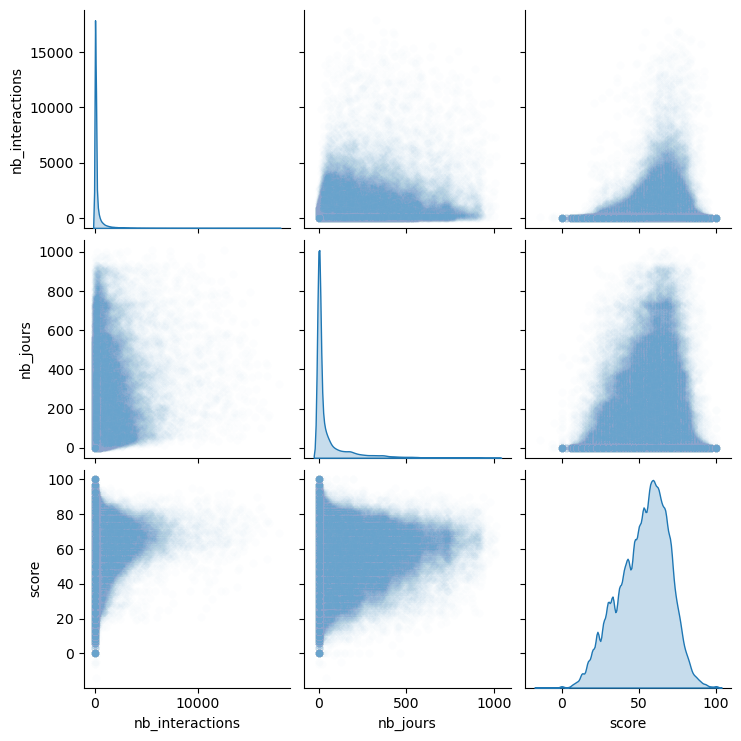

In [8]:
%%time
fig = sns.pairplot(user_info,
                   diag_kind="kde",
                   plot_kws={'alpha': 0.01})
fig.savefig('img/img_eda_user_pairplot.png',
            transparent=True)
plt.close()
Image('img/img_eda_user_pairplot.png')

## 2-2. Nombre d'interactions par utilisateur
Nous avons beaucoup d'outliers sur le nombre d'interactions effectuées. Nous avons trop de utilisateurs avec un nombre d'interactions faibles.

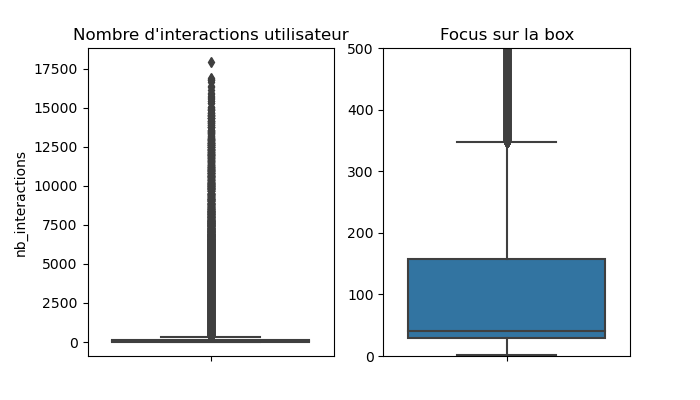

In [9]:
fig, (ax0, ax1) = plt.subplots(nrows=1,ncols=2, sharey=False, figsize=(7,4))
sns.boxplot(y=user_info['nb_interactions'], ax=ax0)
sns.boxplot(y=user_info['nb_interactions'], ax=ax1)
ax0.set(title="Nombre d'interactions utilisateur")
ax1.set(ylim=(0,500), title="Focus sur la box", ylabel="")
fig.savefig('img/img_eda_interaction_boxplot.png',
            transparent=True)
plt.close()
Image('img/img_eda_interaction_boxplot.png')

Il serait bienvenue de nettoyer cette portion afin que le modèle puisse généraliser le mieux possible.

## 2-3. Nombre de jours entre la première interaction et la dernière
Le but étant de prédire correctement l'évolution d'un utilisateur à moyen terme, les étudiants n'ayant pas de continuité dans le temps ne sont pas un bon profil pour l'apprentissage (0 jours par exemple). De même pour ceux qui ont une durée beaucoup trop longue et qui ne correspond pas à un utilisateur lambda (Certains ont plus de 3 ans entre la première interactions et la dernière)

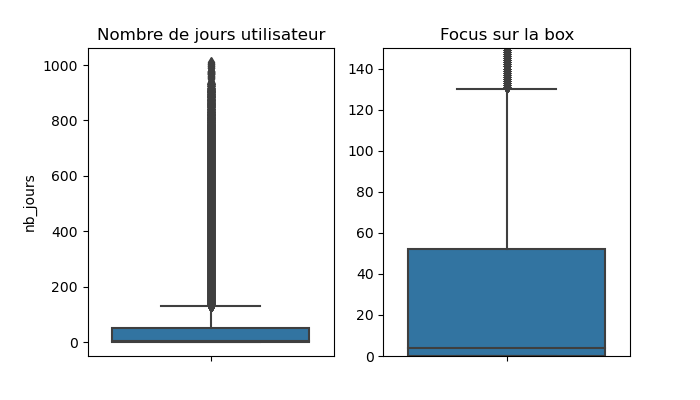

In [10]:
fig, (ax0, ax1) = plt.subplots(nrows=1,ncols=2, sharey=False, figsize=(7,4))
sns.boxplot(y=user_info['nb_jours'], ax=ax0)
sns.boxplot(y=user_info['nb_jours'], ax=ax1)
ax0.set(title="Nombre de jours utilisateur")
ax1.set(ylim=(0,150), title="Focus sur la box", ylabel="")
fig.savefig('img/img_eda_jour_boxplot.png',
            transparent=True)
plt.close()
Image('img/img_eda_jour_boxplot.png')

Il conviendra de nettoyer cette portion afin de permettre à l'algorithme de généraliser au mieux.

## 2-4. Application des filtres

In [11]:
# Filtre des interaction exceptionnelles
q5_int = user_info.nb_interactions.quantile(0.05)
q95_int = user_info.nb_interactions.quantile(0.95)
cond_int = (user_info.nb_interactions > q5_int) & (user_info.nb_interactions < q95_int)

# Filtre des délais exceptionnels
q5_delay = user_info.nb_jours.quantile(0.05)
q95_delay = user_info.nb_jours.quantile(0.95)
cond_delay = (user_info.nb_jours > q5_delay) & (user_info.nb_jours < q95_delay)

reduced_user_info = user_info[cond_int & cond_delay]
reduced_user_info

,nb_interactions,nb_jours,score
user_id,,,
115,46,7,70
5382,128,24,63
8623,112,9,60
12741,271,51,54
40828,93,73,61
...,...,...,...
2147469944,276,29,71
2147470770,228,32,75
2147470777,758,154,68


In [13]:
reduced_n_user = len(reduced_user_info)

reduced_user_rate = round((1 - reduced_n_user / n_user) * 100)
print(f'Les utilisateurs ont été réduits de {reduced_user_rate} %.')

Les utilisateurs ont été réduits de 51 %.


Wall time: 13 s


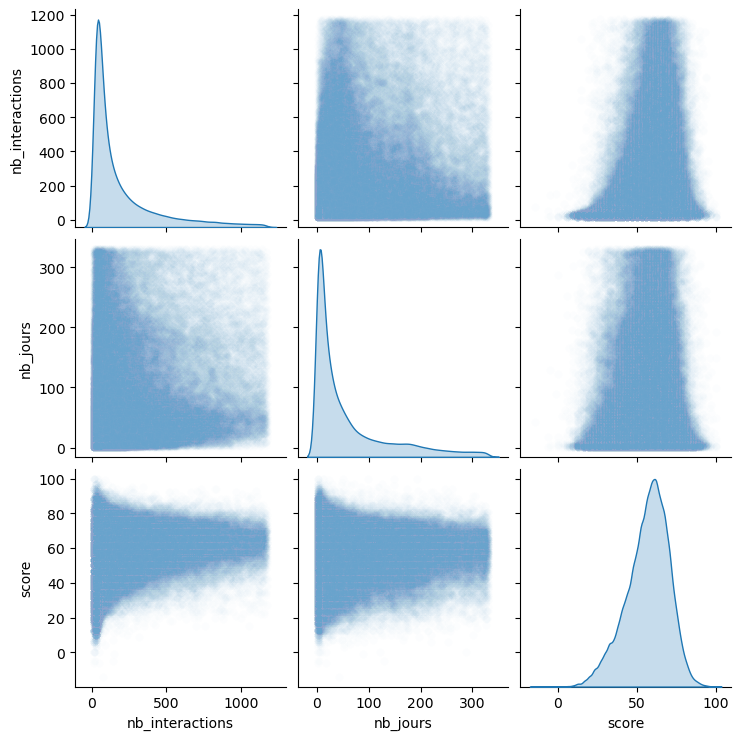

In [12]:
%%time
fig = sns.pairplot(reduced_user_info,
                   diag_kind="kde",
                   plot_kws={'alpha': 0.01})
fig.savefig('img/img_eda_reduced_user_pairplot.png',
            transparent=True)
plt.close()
Image('img/img_eda_reduced_user_pairplot.png')

Les distributions sont plus aérées, les modèles seront ainsi plus ouvert à généralisation.

Je n'interviens pas sur le score : je l'ai calculé à titre indicatif.

In [14]:
# Merge des df sur le user_id
# Je ne conserve que ce qui ont une correspondance
# Application indirecte de mon filtre
reduced_train = pd.merge(train, reduced_user_info, on='user_id')

col = train.columns
reduced_train = reduced_train[col]
reduced_train

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,<NA>
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False
...,...,...,...,...,...,...,...,...,...,...
38201458,101230327,428564420,2147482888,3586,0,22,0,1,18000.0,True
38201459,101230328,428585000,2147482888,6341,0,23,3,1,14000.0,True
38201460,101230329,428613475,2147482888,4212,0,24,3,1,14000.0,True
38201461,101230330,428649406,2147482888,6343,0,25,1,0,22000.0,True


In [15]:
reduced_train_rate = round((1 - len(reduced_train) / len(train)) * 100)
print(f'Les interactions ont été réduites de {reduced_train_rate} %.')

Les interactions ont été réduites de 62 %.


# 3. Traitement des questions

# 4. Ajout des parties liées à l'examen du TOEIC

TO DO
- Sortir les question (conférence)
- Ajouter les parties du toeic (ajout d'un degré de difficulté à la question)

---

In [10]:
path = "C:/riiid-test-answer-prediction/example_test.csv"
example_test = pd.read_csv(path)
example_test

,row_id,group_num,timestamp,user_id,content_id,content_type_id,task_container_id,prior_question_elapsed_time,prior_question_had_explanation,prior_group_answers_correct,prior_group_responses
0,0,0,0,275030867,5729,0,0,NaN,NaN,[],[]
1,1,0,13309898705,554169193,12010,0,4427,19000.0,True,NaN,NaN
2,2,0,4213672059,1720860329,457,0,240,17000.0,True,NaN,NaN
3,3,0,62798072960,288641214,13262,0,266,23000.0,True,NaN,NaN
4,4,0,10585422061,1728340777,6119,0,162,72400.0,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
99,104,3,13167339284,1900527744,3004,0,1179,24667.0,True,NaN,NaN
100,105,3,13167339284,1900527744,3003,0,1179,24667.0,True,NaN,NaN
101,106,3,64497673060,7792299,7908,0,676,19000.0,True,NaN,NaN
102,107,3,62798166743,288641214,9077,0,269,25000.0,True,NaN,NaN


In [18]:
reduced_train_questions.to_pickle("C:/riiid-test-answer-prediction/reduced_riiid_train.pkl.gzip")

In [8]:
%%time

path = "C:/riiid-test-answer-prediction/reduced_riiid_train.pkl.gzip"
train = pd.read_pickle(path)
train = train.astype({'row_id': 'int64',
                      'timestamp': 'int64',
                      'user_id': 'int32',
                      'content_id': 'int16',
                      'content_type_id': 'int8',
                      'task_container_id': 'int16',
                      'user_answer': 'int8',
                      'answered_correctly': 'int8',
                      'prior_question_elapsed_time': 'float32',
                      'prior_question_had_explanation': 'boolean'})

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46485588 entries, 0 to 46485587
Data columns (total 13 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int32  
 3   content_id                      int16  
 4   content_type_id                 int8   
 5   task_container_id               int16  
 6   user_answer                     int8   
 7   answered_correctly              int8   
 8   prior_question_elapsed_time     float32
 9   prior_question_had_explanation  boolean
 10  nb_questions                    int64  
 11  nb_jours                        int64  
 12  score                           int8   
dtypes: boolean(1), float32(1), int16(2), int32(1), int64(4), int8(4)
memory usage: 2.5 GB
Wall time: 5.01 s
